In [4]:
############################
# GPU and CPU Check Code
# KEEP AT THE TOP
############################

# !pip install psutil
# !pip install gputil

import os
import time
import torch
import spacy
import psutil
import pandas as pd
import torch.nn as nn
import multiprocessing

from functools import partial
from datasets import load_dataset
from transformers import BertModel
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

print("IMPORTS DONE")

IMPORTS DONE


In [2]:
# Get the number of CPUs
num_cpus = psutil.cpu_count(logical=False)  # physical cores
num_logical_cpus = psutil.cpu_count(logical=True)  # logical cores

print(f"Number of physical CPUs: {num_cpus}")
print(f"Number of logical CPUs: {num_logical_cpus}")

try:
    import GPUtil

    # Get the number of available GPUs
    gpus = GPUtil.getGPUs()
    num_gpus = len(gpus)

    print(f"Number of GPUs: {num_gpus}")

    for i, gpu in enumerate(gpus):
        print(f"GPU {i + 1}: {gpu.name}")
        print(f"\tUUID: {gpu.uuid}")
        print(f"\tMemory Total: {gpu.memoryTotal} MB")
        print(f"\tMemory Used: {gpu.memoryUsed} MB")
        print(f"\tMemory Free: {gpu.memoryFree} MB")
        print(f"\tGPU Utilization: {gpu.load * 100}%")
        print(f"\tGPU Temperature: {gpu.temperature} °C")
except ImportError:
    print("GPUtil library not found. Cannot check GPU information.")

Number of physical CPUs: 128
Number of logical CPUs: 128
Number of GPUs: 2
GPU 1: NVIDIA A100 80GB PCIe
	UUID: GPU-c9f222a4-cdf9-a690-b27c-fd6ca8dd8832
	Memory Total: 81920.0 MB
	Memory Used: 7.0 MB
	Memory Free: 81042.0 MB
	GPU Utilization: 0.0%
	GPU Temperature: 31.0 °C
GPU 2: NVIDIA A100 80GB PCIe
	UUID: GPU-051052d6-9db8-7e01-b26b-69a92eab9f9e
	Memory Total: 81920.0 MB
	Memory Used: 7.0 MB
	Memory Free: 81042.0 MB
	GPU Utilization: 0.0%
	GPU Temperature: 27.0 °C


In [2]:
# Load spaCy's English model for sentence segmentation
nlp = spacy.load("en_core_web_sm")

# Function for sentence segmentation using spaCy
def segment_sentences(text):
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents]

# Load dataset from Hugging Face datasets library
dataset = load_dataset("trec")

# Extract train and test splits
train_data = dataset['train']
test_data = dataset['test']

# Use 'text' and 'coarse_label' as question and label
train_texts = train_data['text']
train_labels = train_data['coarse_label']

test_texts = test_data['text']
test_labels = test_data['coarse_label']

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def process_data(texts, labels, max_seq_length=512, max_head_tokens=128, max_tail_tokens=382):
    formatted_data = []

    for text, label in zip(texts, labels):
        # Segment sentences using spaCy
        sentences = segment_sentences(text)
        processed_text = " ".join(sentences)

        # Tokenize the processed text using BERT tokenizer
        tokens = tokenizer.tokenize(processed_text)
        # Add [CLS] and [SEP] tokens
        tokens = ['[CLS]'] + tokens + ['[SEP]']

        if len(tokens) > max_seq_length:
            # Keep the first max_head_tokens and the last max_tail_tokens
            head_tokens = tokens[1:max_head_tokens + 1]
            tail_tokens = tokens[-max_tail_tokens:]
            tokens = head_tokens + tail_tokens

        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(input_ids)

        # Padding
        padding_length = max_seq_length - len(input_ids)
        input_ids += [tokenizer.pad_token_id] * padding_length
        attention_mask += [0] * padding_length

        input_ids = torch.tensor(input_ids)
        attention_mask = torch.tensor(attention_mask)

        # Append to formatted data including 'label'
        formatted_data.append({
            'input_ids': input_ids.unsqueeze(0),  # Unsqueeze for batch dimension
            'attention_mask': attention_mask.unsqueeze(0),  # Unsqueeze for batch dimension
            'label': label
        })

    return formatted_data

# Process train and test data
formatted_train_data = process_data(train_texts, train_labels)
formatted_test_data = process_data(test_texts, test_labels)

Found cached dataset trec (/home/vmenon19/.cache/huggingface/datasets/trec/default/2.0.0/f2469cab1b5fceec7249fda55360dfdbd92a7a5b545e91ea0f78ad108ffac1c2)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
# Convert data to PyTorch DataLoader
batch_size = 24

train_inputs = torch.cat([data['input_ids'] for data in formatted_train_data])
train_masks = torch.cat([data['attention_mask'] for data in formatted_train_data])
train_labels = torch.tensor([data['label'] for data in formatted_train_data])

train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_inputs = torch.cat([data['input_ids'] for data in formatted_test_data])
test_masks = torch.cat([data['attention_mask'] for data in formatted_test_data])
test_labels = torch.tensor([data['label'] for data in formatted_test_data])

test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Define BERT model for sequence classification
class BERTSequenceClassifier(nn.Module):
    def __init__(self, num_labels):
        super(BERTSequenceClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

# Initialize the BERT-based sequence classifier model
coarse_labels = dataset['train']['coarse_label']
num_labels = len(set(coarse_labels))

model = BERTSequenceClassifier(num_labels=num_labels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, betas=(0.9, 0.999))
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * len(train_dataloader),
                                            num_training_steps=len(train_dataloader) * 4)

# Training loop with training and validation steps
best_val_accuracy = 0.0
best_model_path = "best_model.pt"

num_epochs = 4
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}:")

    # Training
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        inputs, masks, labels = [tensor.to(device) for tensor in batch]
        outputs = model(inputs, attention_mask=masks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    # Evaluation on validation set
    model.eval()
    total_eval_loss = 0
    total_eval_accuracy = 0

    for batch in test_dataloader:
        with torch.no_grad():
            inputs, masks, labels = [tensor.to(device) for tensor in batch]
            outputs = model(inputs, attention_mask=masks)
            loss = criterion(outputs, labels)
            total_eval_loss += loss.item()

            logits = outputs.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()
            total_eval_accuracy += (logits.argmax(axis=1) == label_ids).mean()

    avg_val_loss = total_eval_loss / len(test_dataloader)
    avg_val_accuracy = total_eval_accuracy / len(test_dataloader)

    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}")

    # Save the best model based on validation accuracy
    if avg_val_accuracy > best_val_accuracy:
        best_val_accuracy = avg_val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved.")

# Load the best model for testing
best_model = BERTSequenceClassifier(num_labels=num_labels)
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

# Evaluation on the test set using the best model
best_model.eval()
total_test_loss = 0
total_test_accuracy = 0

for batch in test_dataloader:
    with torch.no_grad():
        inputs, masks, labels = [tensor.to(device) for tensor in batch]
        outputs = best_model(inputs, attention_mask=masks)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()

        logits = outputs.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        total_test_accuracy += (logits.argmax(axis=1) == label_ids).sum()

avg_test_loss = total_test_loss / len(test_dataloader)
test_accuracy = total_test_accuracy / len(test_dataset)
test_error_rate = 1 - test_accuracy

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Error Rate: {test_error_rate:.4f}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/data/user/vmenon19/Conda_Env/nlp2023v2/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is depre


Epoch 1/4:
Average Training Loss: 0.7755
Validation Loss: 0.2081, Validation Accuracy: 0.9341
Best model saved.

Epoch 2/4:
Average Training Loss: 0.1718
Validation Loss: 0.1458, Validation Accuracy: 0.9635
Best model saved.

Epoch 3/4:
Average Training Loss: 0.0828
Validation Loss: 0.1243, Validation Accuracy: 0.9698
Best model saved.

Epoch 4/4:
Average Training Loss: 0.0492
Validation Loss: 0.1216, Validation Accuracy: 0.9698


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test Loss: 0.1243
Test Accuracy: 0.9700
Test Error Rate: 0.0300


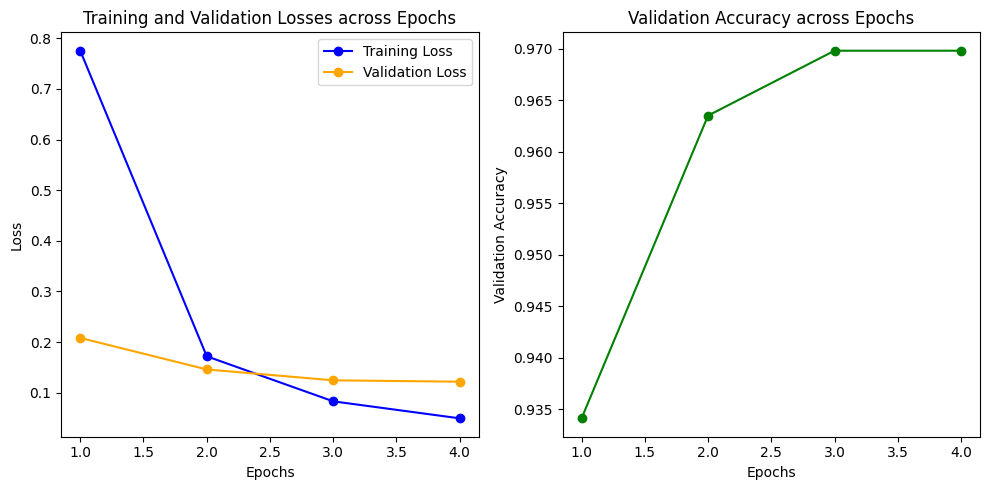

In [6]:
import matplotlib.pyplot as plt

# Epoch-wise data
epochs = [1, 2, 3, 4]
training_losses = [0.7755, 0.1718, 0.0828, 0.0492]
validation_losses = [0.2081, 0.1458, 0.1243, 0.1216]
validation_accuracies = [0.9341, 0.9635, 0.9698, 0.9698]

# Plotting training and validation losses across epochs
plt.figure(figsize=(10, 5))

# Training Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, training_losses, marker='o', color='blue', label='Training Loss')
plt.plot(epochs, validation_losses, marker='o', color='orange', label='Validation Loss')
plt.title('Training and Validation Losses across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, validation_accuracies, marker='o', color='green')
plt.title('Validation Accuracy across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

plt.tight_layout()
plt.show()